#**Librerías**

#**Contextualización**
En la empresa de seguridad SecurityTech y vigilancia se busca innovar en sus sistemas de seguridad un modelo de detección de rostros faciales que permita identificar la persona y genere una registro de la persona identificada, este modelo va a ser entrenado mediante el dataset Labeless Faces in the Wild(LFW) el cual normalizaremos para ser usado bajo escala de grises.



# **Pruebas con algoritmos de ML**

*   Gaussian Naive Bayes
*   Decision Tree
*   Random Forest
*   Support Vector Machine

##01_Importación y separación de datos para su manejo

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
import numpy as np
from sklearn.datasets import fetch_lfw_people

# ---------------------------------------------------------
# 1. Cargar dataset asegurando MÍNIMO 100 fotos por persona
# ---------------------------------------------------------
# Cambiamos min_faces_per_person a 100.
# Esto filtrará automáticamente a las clases que no llegan a este número
# (Ej. Ariel Sharon y Hugo Chavez quedarán fuera).
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

X_raw = lfw_people.data
y_raw = lfw_people.target
images_raw = lfw_people.images
target_names = lfw_people.target_names

print(f"Personas disponibles con >100 imágenes: {len(target_names)}")
print(f"Nombres: {target_names}")

# ---------------------------------------------------------
# 2. Seleccionar aleatoriamente 100 imágenes EXACTAS por clase
# ---------------------------------------------------------
indices_balanced = []
IMAGENES_POR_CLASE = 100

# Fijamos semilla para que la selección sea reproducible
np.random.seed(42)

for class_idx in range(len(target_names)):
    # Encontrar todos los índices donde aparece la persona 'class_idx'
    indices_person = np.where(y_raw == class_idx)[0]

    # Seleccionar 100 al azar (sin reemplazo para no repetir fotos)
    # Nota: Como ya filtramos en la carga, garantizamos que len(indices_person) >= 100
    selected_indices = np.random.choice(indices_person, IMAGENES_POR_CLASE, replace=False)

    indices_balanced.extend(selected_indices)

# Ordenamos los índices para mantener el orden relativo (opcional)
indices_balanced = np.sort(indices_balanced)

# ---------------------------------------------------------
# 3. Crear los arrays filtrados finales (X, y, images)
# ---------------------------------------------------------
X_filtered = X_raw[indices_balanced]
y_filtered = y_raw[indices_balanced]
images_filtered = images_raw[indices_balanced]

# Actualizar target_names (en este caso son los mismos, pero es buena práctica)
target_names_filtered = target_names

# ---------------------------------------------------------
# 4. Verificación Final
# ---------------------------------------------------------
print("\n--- Dataset Final Balanceado (X_filtered) ---")
print(f"Dimensiones de X_filtered: {X_filtered.shape}")
print(f"Total de Clases: {len(target_names_filtered)}")

print("\nConteo por clase:")
unique, counts = np.unique(y_filtered, return_counts=True)
for i, count in zip(unique, counts):
    print(f"  {target_names_filtered[i]:<20}: {count} imágenes")

Personas disponibles con >100 imágenes: 5
Nombres: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']

--- Dataset Final Balanceado (X_filtered) ---
Dimensiones de X_filtered: (500, 1850)
Total de Clases: 5

Conteo por clase:
  Colin Powell        : 100 imágenes
  Donald Rumsfeld     : 100 imágenes
  George W Bush       : 100 imágenes
  Gerhard Schroeder   : 100 imágenes
  Tony Blair          : 100 imágenes


##02_Visualizar imágenes

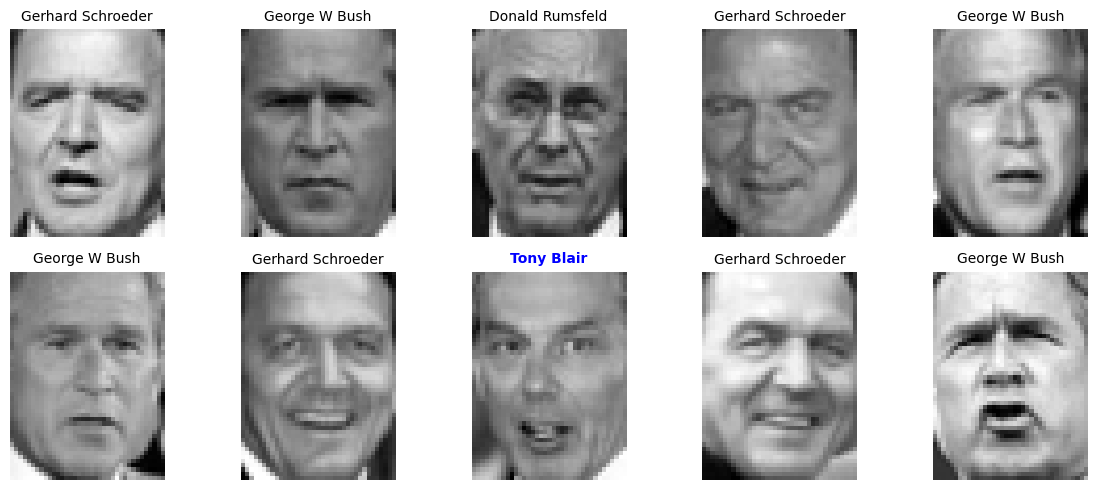

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------------
# Configuración
# -------------------------------------------------------------------
# 1. Identificar cuál es la etiqueta de TU clase (asumimos que es la última agregada)
# Si usaste el código anterior, tus fotos están al final, así que tomamos la etiqueta del último elemento
mi_etiqueta = y_filtered[-1]

# 2. Separar los índices: Los tuyos vs. El resto del mundo
indices_mios = np.where(y_filtered == mi_etiqueta)[0]
indices_otros = np.where(y_filtered != mi_etiqueta)[0]

# -------------------------------------------------------------------
# Selección de imágenes para el Grid
# -------------------------------------------------------------------
# Elegimos 1 foto tuya al azar
idx_mio_seleccionado = np.random.choice(indices_mios, 1, replace=False)

# Elegimos 9 fotos de los otros al azar
idx_otros_seleccionados = np.random.choice(indices_otros, 9, replace=False)

# Concatenamos los índices (1 tuyo + 9 otros)
indices_visualizar = np.concatenate([idx_otros_seleccionados, idx_mio_seleccionado])

# ¡IMPORTANTE! Mezclamos (shuffle) para que tu foto no salga siempre al final,
# sino "escondida" entre las demás como en el dataset real.
np.random.shuffle(indices_visualizar)

# -------------------------------------------------------------------
# Graficar (Estilo idéntico a tu ejemplo)
# -------------------------------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(12, 5)) # 2 filas, 5 columnas

for i, ax in enumerate(axes.flat):
    # Obtenemos el índice real para esta posición del grid
    idx_real = indices_visualizar[i]

    # Mostramos la imagen
    ax.imshow(images_filtered[idx_real], cmap="gray")

    # Obtenemos el nombre correspondiente
    etiqueta_num = y_filtered[idx_real]
    nombre = target_names_filtered[etiqueta_num]

    # Ponemos el título
    # Truco visual: Si es tu foto, ponemos el título en azul negrita para que la ubiques rápido,
    # el resto en negro normal como en la imagen original.
    if etiqueta_num == mi_etiqueta:
        ax.set_title(nombre, fontsize=10, color='blue', fontweight='bold')
    else:
        ax.set_title(nombre, fontsize=10, color='black')

    ax.axis("off")

plt.tight_layout()
plt.show()

##03_Normalización de datos para la escala de grises

In [ ]:
X_filtered = X_filtered / 255.0

##04_Dividir en entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.25, random_state=42, stratify=y_filtered
)


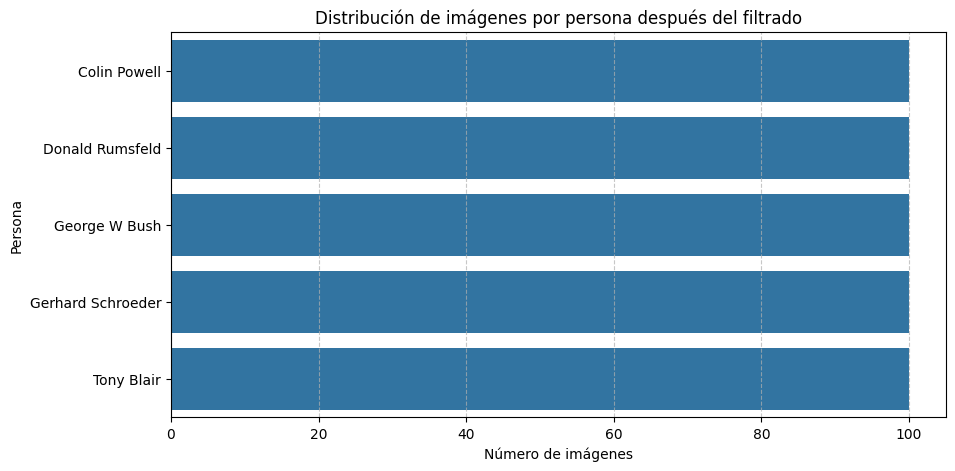

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ===============================================================
# 📊 2. DISTRIBUCIÓN DE IMÁGENES POR PERSONA
# ===============================================================

# 1. Obtenemos los índices únicos y sus conteos
unique, counts = np.unique(y_filtered, return_counts=True)

# 2. CORRECCIÓN: Seleccionamos solo los nombres que corresponden a esos índices únicos.
# Esto asegura que la lista de nombres tenga EXACTAMENTE el mismo largo que la lista de conteos.
names_present = target_names_filtered[unique]

plt.figure(figsize=(10, 5))

# Usamos 'names_present' en lugar de 'target_names_filtered'
sns.barplot(x=counts, y=names_present)

plt.xlabel("Número de imágenes")
plt.ylabel("Persona")
plt.title("Distribución de imágenes por persona después del filtrado")
plt.grid(axis='x', linestyle='--', alpha=0.7) # Agregué una grilla suave para mejor lectura
plt.show()

##05_Reducción de dimensionalidad PCA

El PCA permite una reducción de dimensión sin perder información en el proceso, este proceso se realiza para permitir un mejor rendimniento ya que las imagenes cuentas con miles de pixeles y el analizar uno a uno generar un gasto computacional mayor.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=150, whiten=True, random_state=42)


##06_Clasificar usando un SVM y kernel RBF


En nuestro modelo de reconocimiento facial, el SVM con kernel RBF se encarga de reconocer a qué persona pertenece una imagen. Primero, el modelo recibe los rostros convertidos en números y busca patrones que diferencien a cada individuo. El SVM aprende a separar las caras de distintas personas trazando límites entre ellas. Como los rostros no se distinguen con líneas rectas, el kernel RBF permite crear fronteras curvas y flexibles que se adaptan mejor a las diferencias reales entre las caras. Así, el modelo puede identificar correctamente a una persona, incluso si la imagen cambia un poco en expresión o iluminación.


In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', probability=True)


##07_Creamor un pipeline para que los algoritmos PCA y SVM estén automatizados

In [ ]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(pca, svc)

##08_Entrenamiento y Evaluación del modelo



In [ ]:
model.fit(X_train_filtered, y_train_filtered)

Pipeline(steps=[('pca', PCA(n_components=150, random_state=42, whiten=True)),
                ('svc', SVC(kernel='linear', probability=True))])

In [ ]:
y_pred = model.predict(X_test_filtered)

etiquetas_reales = np.unique(np.concatenate((y_test_filtered, y_pred)))

# 2. Filtrar la lista de nombres para quedarnos solo con los que coinciden con esas etiquetas
# Esto elimina cualquier nombre "fantasma" que se haya colado en la lista por error
nombres_reales = target_names_filtered[etiquetas_reales]

print(f"Clases encontradas en los datos: {len(etiquetas_reales)}")
print(f"Nombres disponibles para reportar: {len(nombres_reales)}")
print("-" * 30)

# 3. Generar el reporte usando SOLO lo que está verificado
print(classification_report(y_test_filtered, y_pred,
                            labels=etiquetas_reales,
                            target_names=nombres_reales))




Clases encontradas en los datos: 5
Nombres disponibles para reportar: 5
------------------------------
                   precision    recall  f1-score   support

     Colin Powell       0.83      0.80      0.82        25
  Donald Rumsfeld       0.81      0.84      0.82        25
    George W Bush       0.84      0.84      0.84        25
Gerhard Schroeder       0.88      0.84      0.86        25
       Tony Blair       0.77      0.80      0.78        25

         accuracy                           0.82       125
        macro avg       0.83      0.82      0.82       125
     weighted avg       0.83      0.82      0.82       125



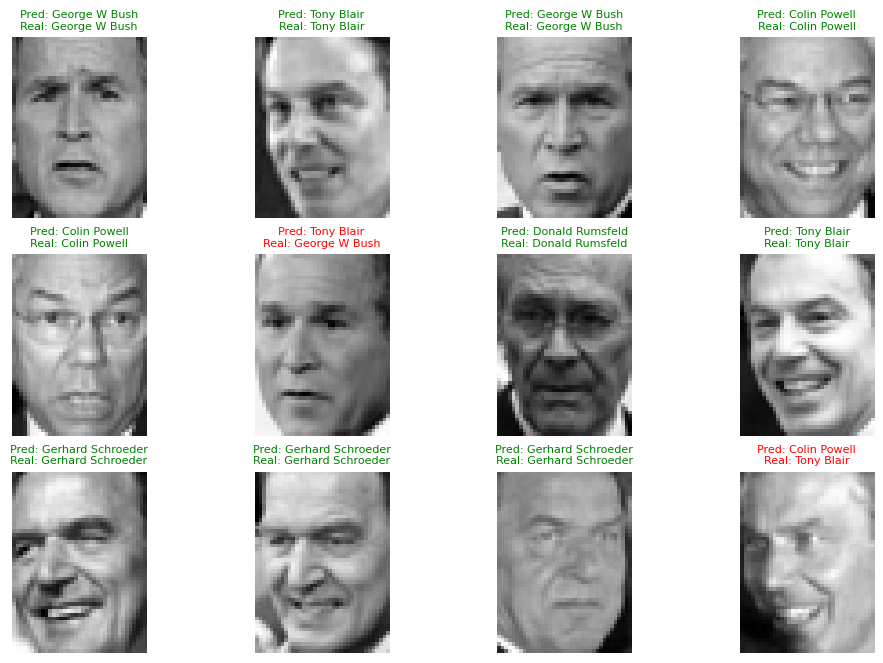

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_filtered[i].reshape(images_filtered.shape[1], images_filtered.shape[2]), cmap="gray")
    ax.set_title(f"Pred: {target_names[y_pred[i]]}\nReal: {target_names[y_test_filtered[i]]}",
    fontsize=8, color="green" if y_pred[i] == y_test_filtered[i] else "red")
    ax.axis("off")
plt.show()

# **Pruebas de Machine Learning**

## Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()

In [ ]:
gnb.fit(X_train_filtered, y_train_filtered)

GaussianNB()

In [ ]:
from sklearn.metrics import classification_report

y_pred = gnb.predict(X_test_filtered)

etiquetas_reales = np.unique(np.concatenate((y_test_filtered, y_pred)))

nombres_reales = target_names_filtered[etiquetas_reales]

print(f"Clases encontradas en los datos: {len(etiquetas_reales)}")
print(f"Nombres disponibles para reportar: {len(nombres_reales)}")
print("-" * 30)

# 3. Generar el reporte usando SOLO lo que está verificado
print(classification_report(y_test_filtered, y_pred,
                            labels=etiquetas_reales,
                            target_names=nombres_reales))

Clases encontradas en los datos: 5
Nombres disponibles para reportar: 5
------------------------------
                   precision    recall  f1-score   support

     Colin Powell       0.44      0.84      0.58        25
  Donald Rumsfeld       0.69      0.44      0.54        25
    George W Bush       0.56      0.40      0.47        25
Gerhard Schroeder       0.25      0.24      0.24        25
       Tony Blair       0.53      0.40      0.45        25

         accuracy                           0.46       125
        macro avg       0.49      0.46      0.46       125
     weighted avg       0.49      0.46      0.46       125



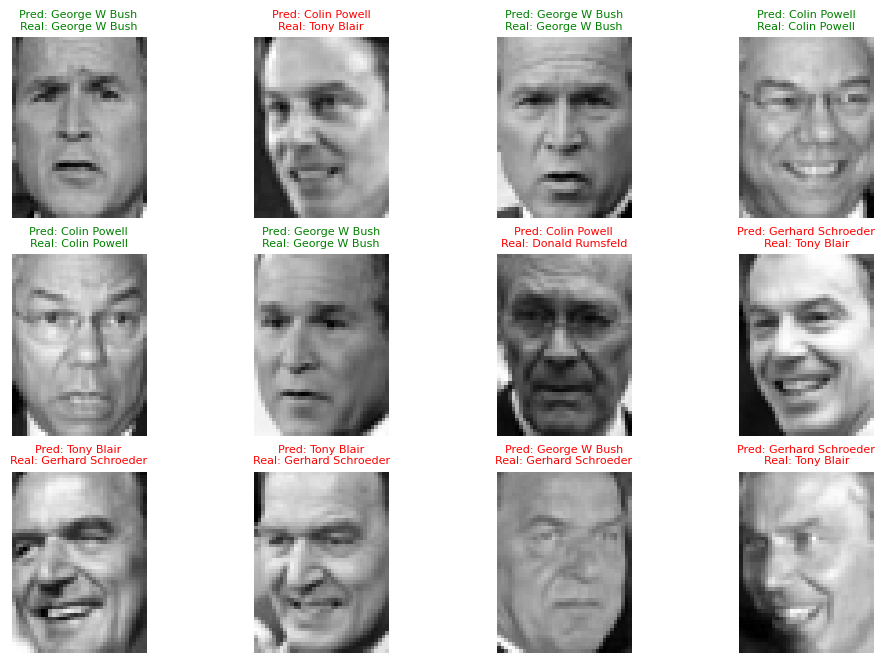

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_filtered[i].reshape(images_filtered.shape[1], images_filtered.shape[2]), cmap="gray")
    ax.set_title(f"Pred: {target_names[y_pred[i]]}\nReal: {target_names[y_test_filtered[i]]}",
    fontsize=8, color="green" if y_pred[i] == y_test_filtered[i] else "red")
    ax.axis("off")
plt.show()

## Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=50)

In [ ]:
rf.fit(X_train_filtered, y_train_filtered)

RandomForestClassifier(max_depth=50)

In [ ]:
from sklearn.metrics import classification_report

y_pred = rf.predict(X_test_filtered)

etiquetas_reales = np.unique(np.concatenate((y_test_filtered, y_pred)))

nombres_reales = target_names_filtered[etiquetas_reales]

print(f"Clases encontradas en los datos: {len(etiquetas_reales)}")
print(f"Nombres disponibles para reportar: {len(nombres_reales)}")
print("-" * 30)

# 3. Generar el reporte usando SOLO lo que está verificado
print(classification_report(y_test_filtered, y_pred,
                            labels=etiquetas_reales,
                            target_names=nombres_reales))

Clases encontradas en los datos: 5
Nombres disponibles para reportar: 5
------------------------------
                   precision    recall  f1-score   support

     Colin Powell       0.67      0.80      0.73        25
  Donald Rumsfeld       0.83      0.60      0.70        25
    George W Bush       0.76      0.76      0.76        25
Gerhard Schroeder       0.57      0.68      0.62        25
       Tony Blair       0.73      0.64      0.68        25

         accuracy                           0.70       125
        macro avg       0.71      0.70      0.70       125
     weighted avg       0.71      0.70      0.70       125



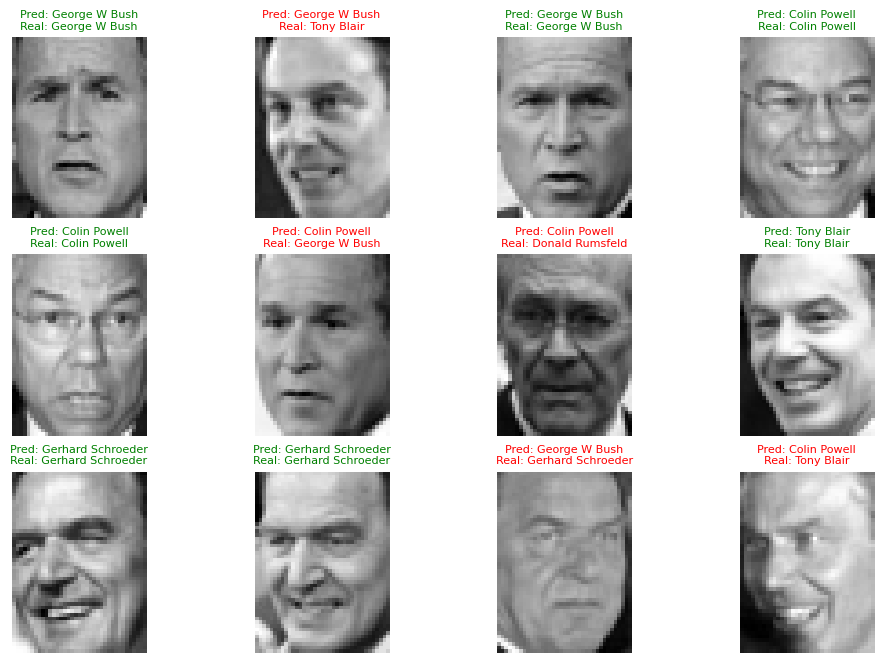

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_filtered[i].reshape(images_filtered.shape[1], images_filtered.shape[2]), cmap="gray")
    ax.set_title(f"Pred: {target_names[y_pred[i]]}\nReal: {target_names[y_test_filtered[i]]}",
    fontsize=8, color="green" if y_pred[i] == y_test_filtered[i] else "red")
    ax.axis("off")
plt.show()

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth=50)

In [ ]:
dt.fit(X_train_filtered, y_train_filtered)

DecisionTreeClassifier(max_depth=50)

In [ ]:
from sklearn.metrics import classification_report

y_pred = dt.predict(X_test_filtered)

etiquetas_reales = np.unique(np.concatenate((y_test_filtered, y_pred)))

nombres_reales = target_names_filtered[etiquetas_reales]

print(f"Clases encontradas en los datos: {len(etiquetas_reales)}")
print(f"Nombres disponibles para reportar: {len(nombres_reales)}")
print("-" * 30)

# 3. Generar el reporte usando SOLO lo que está verificado
print(classification_report(y_test_filtered, y_pred,
                            labels=etiquetas_reales,
                            target_names=nombres_reales))

Clases encontradas en los datos: 5
Nombres disponibles para reportar: 5
------------------------------
                   precision    recall  f1-score   support

     Colin Powell       0.48      0.44      0.46        25
  Donald Rumsfeld       0.43      0.48      0.45        25
    George W Bush       0.27      0.24      0.26        25
Gerhard Schroeder       0.33      0.40      0.36        25
       Tony Blair       0.41      0.36      0.38        25

         accuracy                           0.38       125
        macro avg       0.38      0.38      0.38       125
     weighted avg       0.38      0.38      0.38       125



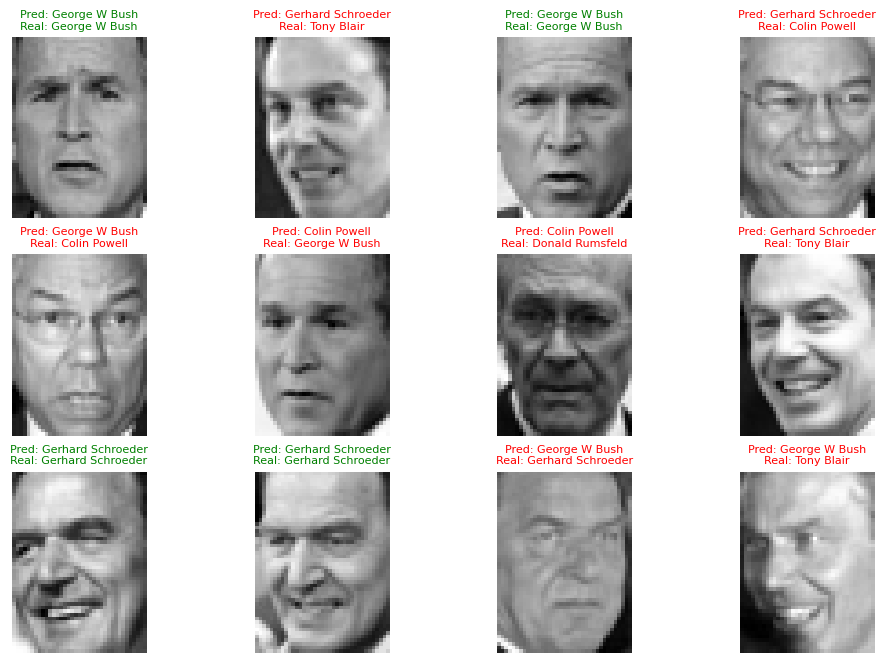

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_filtered[i].reshape(images_filtered.shape[1], images_filtered.shape[2]), cmap="gray")
    ax.set_title(f"Pred: {target_names[y_pred[i]]}\nReal: {target_names[y_test_filtered[i]]}",
    fontsize=8, color="green" if y_pred[i] == y_test_filtered[i] else "red")
    ax.axis("off")
plt.show()

 ## SVM

In [ ]:
svc = SVC(kernel='linear', probability=True)

Nota: No uses rbf para embeddings de alto nivel — tiende a sobreajustar.

In [ ]:
svc.fit(X_train_filtered, y_train_filtered)

SVC(kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import classification_report

y_pred = svc.predict(X_test_filtered)

etiquetas_reales = np.unique(np.concatenate((y_test_filtered, y_pred)))

nombres_reales = target_names_filtered[etiquetas_reales]

print(f"Clases encontradas en los datos: {len(etiquetas_reales)}")
print(f"Nombres disponibles para reportar: {len(nombres_reales)}")
print("-" * 30)

# 3. Generar el reporte usando SOLO lo que está verificado
print(classification_report(y_test_filtered, y_pred,
                            labels=etiquetas_reales,
                            target_names=nombres_reales))

Clases encontradas en los datos: 5
Nombres disponibles para reportar: 5
------------------------------
                   precision    recall  f1-score   support

     Colin Powell       0.44      0.76      0.56        25
  Donald Rumsfeld       0.62      0.32      0.42        25
    George W Bush       0.56      0.60      0.58        25
Gerhard Schroeder       0.35      0.28      0.31        25
       Tony Blair       0.45      0.40      0.43        25

         accuracy                           0.47       125
        macro avg       0.48      0.47      0.46       125
     weighted avg       0.48      0.47      0.46       125



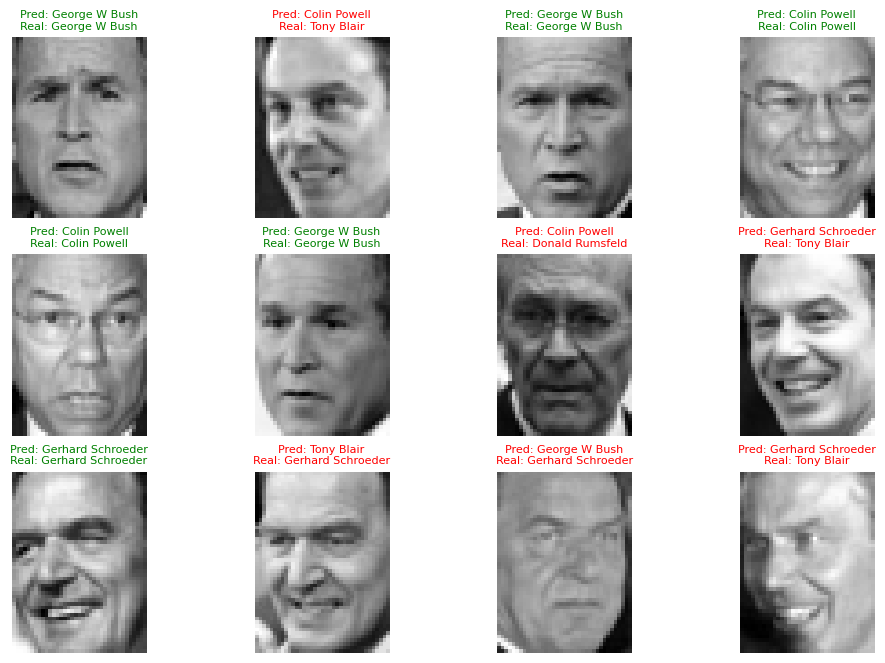

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_filtered[i].reshape(images_filtered.shape[1], images_filtered.shape[2]), cmap="gray")
    ax.set_title(f"Pred: {target_names[y_pred[i]]}\nReal: {target_names[y_test_filtered[i]]}",
    fontsize=8, color="green" if y_pred[i] == y_test_filtered[i] else "red")
    ax.axis("off")
plt.show()

Nota:

**Modelos SVC sin PCA**

El kernel lineal de SVC sin reducción de dimensionalidad suele tener problemas para separar clases en datos de imágenes, especialmente cuando el número de dimensiones (pixeles) es muy alto.

En datasets como LFW, cada imagen puede tener miles de características (una por píxel), y muchas de ellas no aportan información relevante, lo que genera ruido y dificulta que el SVC aprenda fronteras óptimas.

Cuando el modelo no logra separar bien las clases, puede terminar prediciendo únicamente una o unas pocas clases mayoritarias, ignorando completamente las menos representadas, de ahí la advertencia de "precision ill-defined".

**SVC con PCA**

PCA (Análisis de Componentes Principales) reduce la dimensionalidad del problema, extrayendo las características más relevantes. Esto filtra el ruido y concentra la información en menos dimensiones.

Gracias a esto, el SVC puede encontrar fronteras de decisión más claras y no se ve tan afectado por la “maldición de la dimensionalidad” (demasiadas variables irrelevantes).

El resultado es que el modelo predice más clases correctamente y no deja etiquetas completamente sin predecir, eliminando la advertencia.

**Resumen**

Sin PCA: El SVC lineal no logra separar bien las clases por exceso de dimensiones y ruido, llevando a que ignore algunas clases.

Con PCA: La reducción del espacio a las componentes principales permite que el SVC capture mejor las relaciones y prediga correctamente todas o la mayoría de las clases.

# **DEEP LEARNING**

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

In [ ]:
y_train_categorical = to_categorical(y_train_filtered)
y_test_categorical = to_categorical(y_test_filtered)

In [ ]:
n_clases = len(np.unique(y_filtered))
print(n_clases)

5


In [ ]:
model_dl = Sequential([
    Input(shape=(X_filtered.shape[1],)),           # Capa de entrada recomendada
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(target_names_filtered), activation='softmax')
])

model_dl.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       947,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,116,165 (4.26 MB)

 Trainable params: 1,114,373 (4.25 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
optimizer = Adam(learning_rate=0.001)

model_dl.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',  # Mantener si usas labels enteros
    metrics=['accuracy']
)

# Callbacks para mejorar el entrenamiento
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Entrenamiento con callbacks
history = model_dl.fit(
    X_train_filtered,  # o X_train_scaled
    y_train_filtered,
    epochs=100,  # Más épocas con early stopping
    batch_size=32,
    validation_data=(X_test_filtered, y_test_filtered),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9651 - loss: 0.4331 - val_accuracy: 0.4640 - val_loss: 3.2967 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9676 - loss: 0.3897 - val_accuracy: 0.5760 - val_loss: 2.3597 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9738 - loss: 0.3675 - val_accuracy: 0.2080 - val_loss: 13.5242 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9579 - loss: 0.3932 - val_accuracy: 0.3520 - val_loss: 4.0845 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9735 - loss: 0.4003 - val_accuracy: 0.6080 - val_loss: 2.1950 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9811 - loss: 0.3483 - val_accuracy: 0.5760 - val_loss: 2.6301 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9836 - loss: 0.3390 -

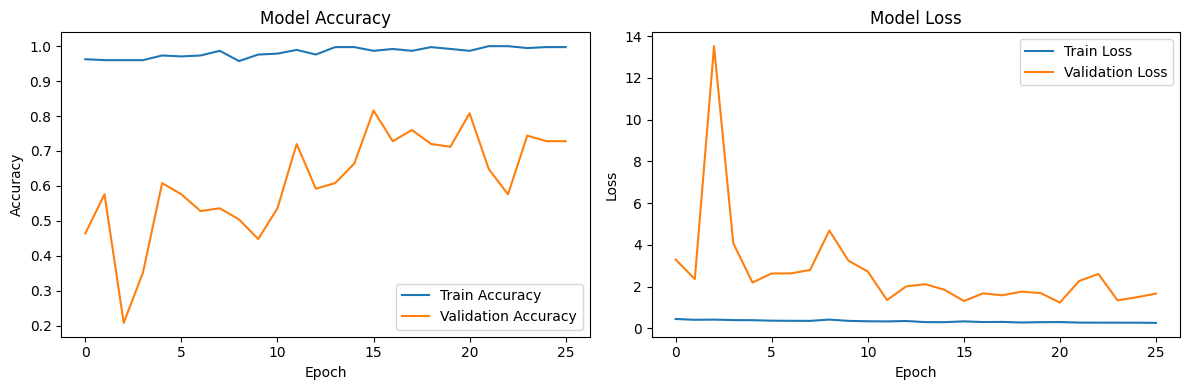

In [ ]:
import matplotlib.pyplot as plt

# Graficar evolución del entrenamiento
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


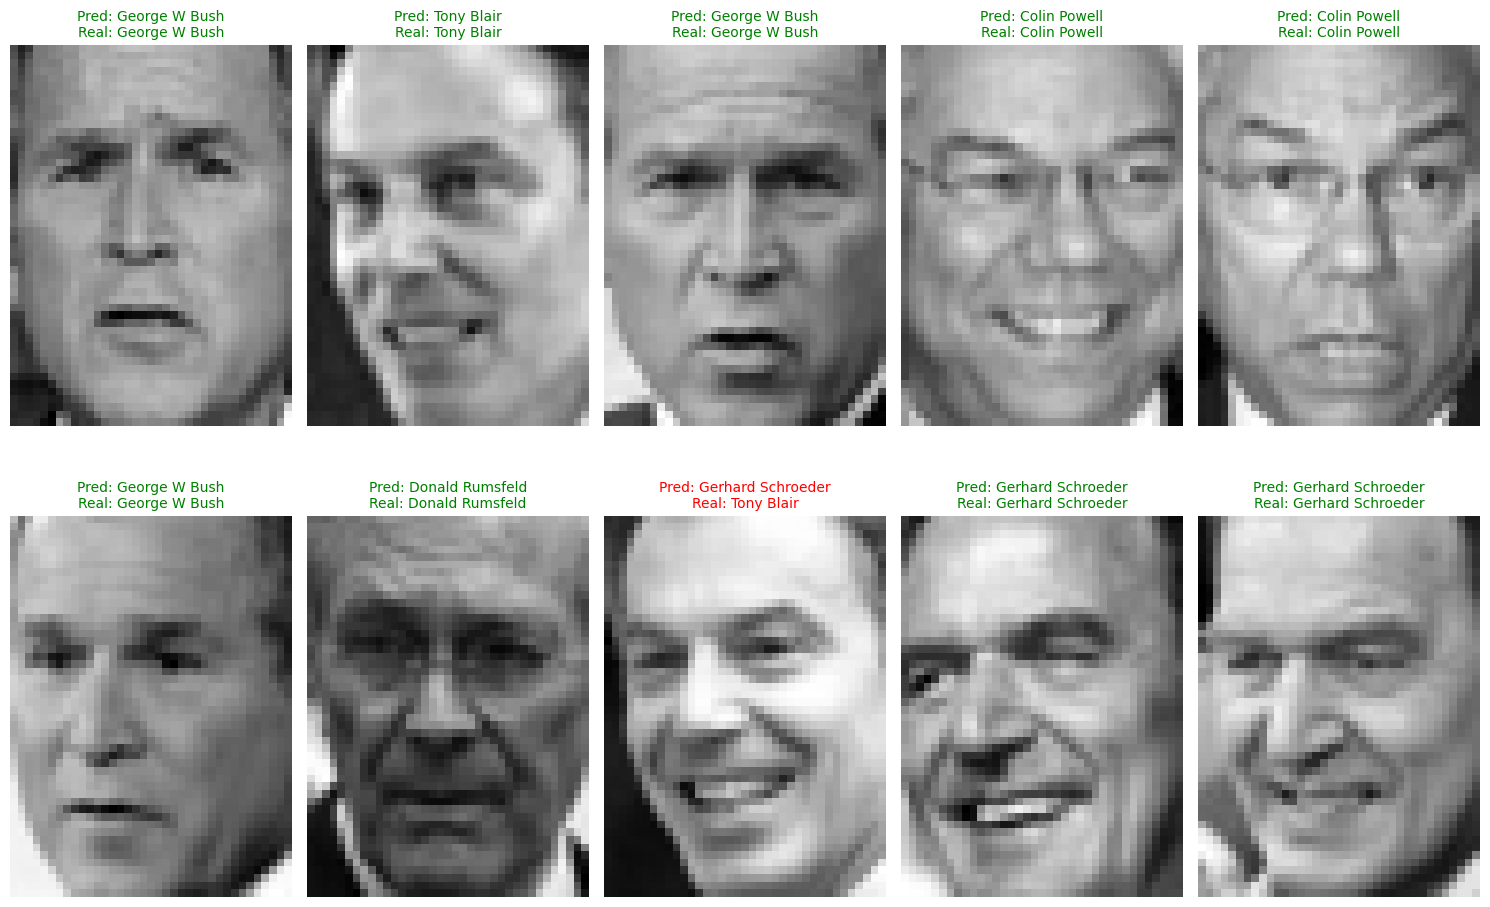

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hacer predicciones
y_pred = model_dl.predict(X_test_filtered)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener los nombres reales de las clases
class_names = target_names_filtered

# Obtener dimensiones correctas de las imágenes
img_height = images_filtered.shape[1]
img_width = images_filtered.shape[2]

# Mostrar predicciones CORREGIDO
plt.figure(figsize=(15, 10))
for i in range(min(10, len(X_test_filtered))):  # Mostrar máximo 10 imágenes
    plt.subplot(2, 5, i + 1)

    # Reconstruir la imagen con las dimensiones correctas
    img = X_test_filtered[i].reshape(img_height, img_width)

    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Obtener predicción y etiqueta real
    pred_label = class_names[y_pred_classes[i]]
    true_label = class_names[y_test_filtered[i]]

    # Color del texto: verde si es correcto, rojo si es incorrecto
    color = 'green' if pred_label == true_label else 'red'

    plt.title(f'Pred: {pred_label}\nReal: {true_label}',
              color=color, fontsize=10)

plt.tight_layout()
plt.show()

## **Metricas**

In [ ]:
# Hacer predicciones
y_pred = model_dl.predict(X_test_filtered)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcular métricas
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_filtered, y_pred_classes, average=None
)

# Crear DataFrame con las métricas
metrics_df = pd.DataFrame({
    'Clase': target_names_filtered,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("MÉTRICAS POR CLASE:")
print("=" * 60)
print(metrics_df.round(3))

# Mostrar reporte de clasificación completo
print("\n" + "=" * 60)
print("REPORTE DE CLASIFICACIÓN COMPLETO")
print("=" * 60)
print(classification_report(y_test_filtered, y_pred_classes,
                          target_names=target_names_filtered))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
MÉTRICAS POR CLASE:
               Clase  Precision  Recall  F1-Score  Support
0       Colin Powell      1.000    0.64     0.780       25
1    Donald Rumsfeld      0.800    0.80     0.800       25
2      George W Bush      0.758    1.00     0.862       25
3  Gerhard Schroeder      0.733    0.88     0.800       25
4         Tony Blair      0.905    0.76     0.826       25

REPORTE DE CLASIFICACIÓN COMPLETO
                   precision    recall  f1-score   support

     Colin Powell       1.00      0.64      0.78        25
  Donald Rumsfeld       0.80      0.80      0.80        25
    George W Bush       0.76      1.00      0.86        25
Gerhard Schroeder       0.73      0.88      0.80        25
       Tony Blair       0.90      0.76      0.83        25

         accuracy                           0.82       125
        macro avg       0.84      0.82      0.81       125
     weighted avg       0.84      0.82      0.81       125



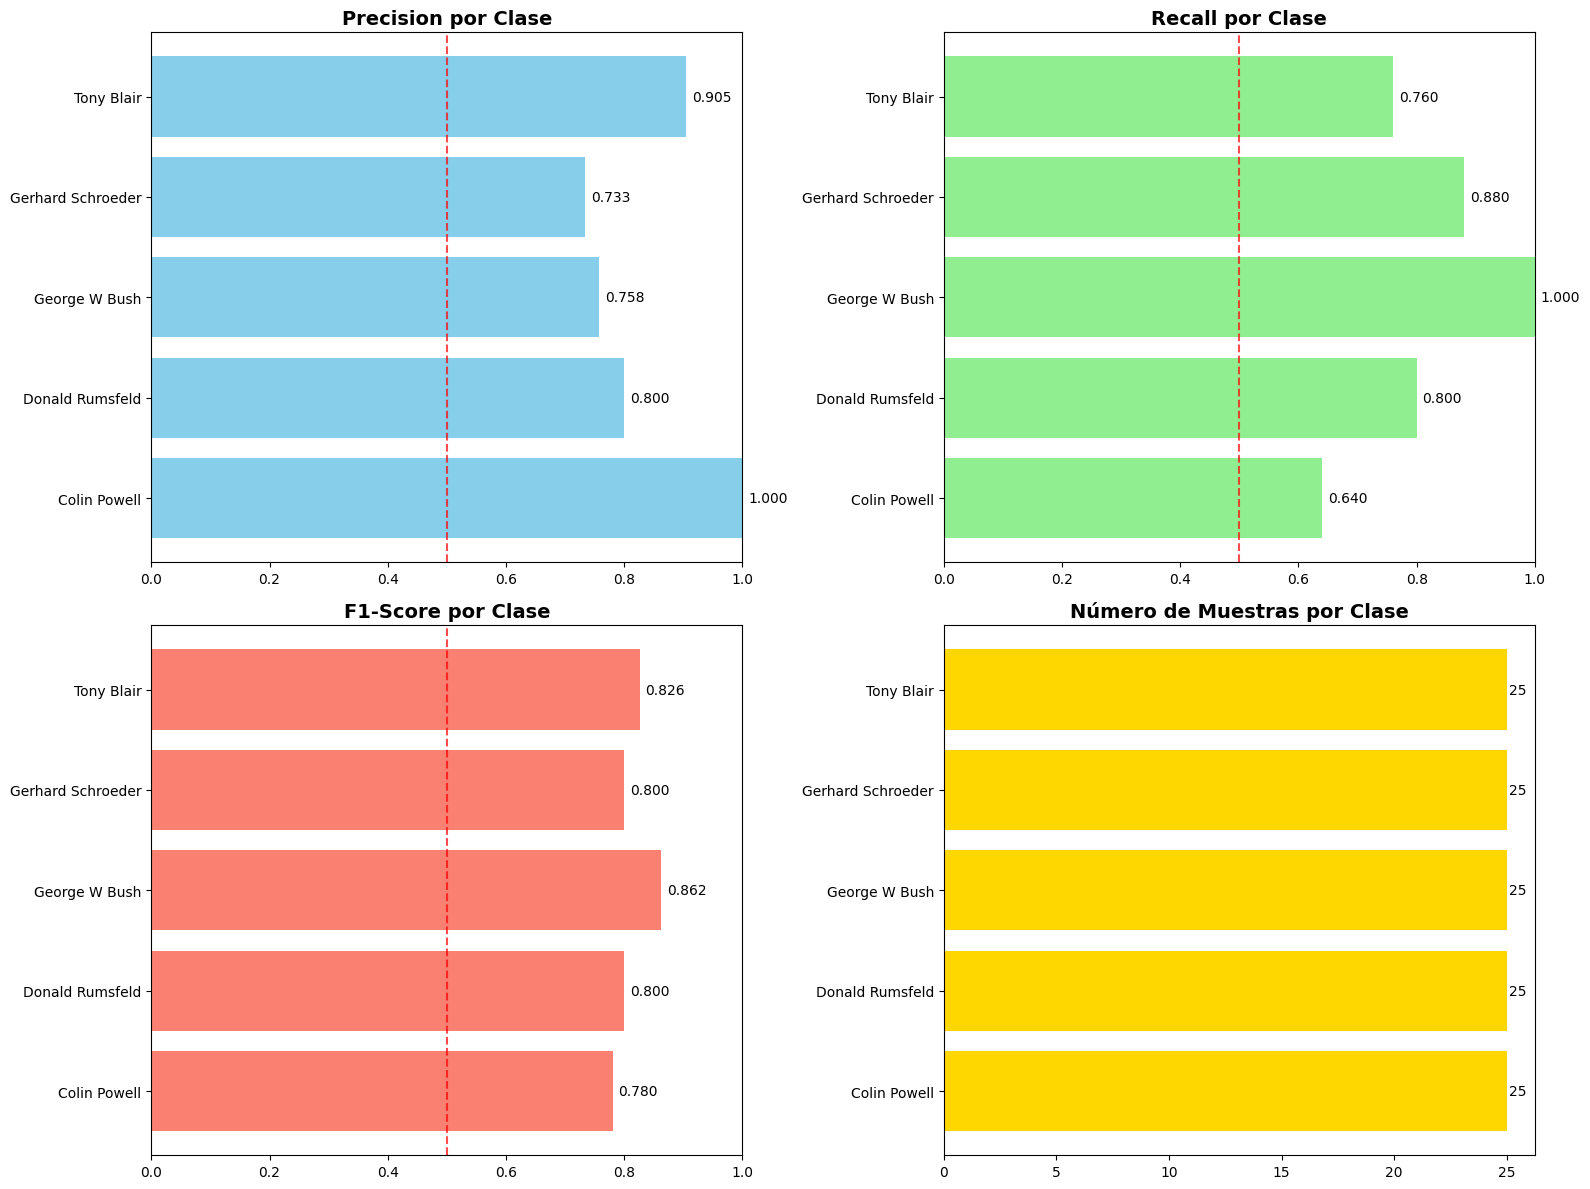

In [ ]:
# Gráfico de métricas por clase
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Precision por clase
axes[0, 0].barh(metrics_df['Clase'], metrics_df['Precision'], color='skyblue')
axes[0, 0].set_title('Precision por Clase', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim(0, 1)
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral 0.5')
for i, v in enumerate(metrics_df['Precision']):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Recall por clase
axes[0, 1].barh(metrics_df['Clase'], metrics_df['Recall'], color='lightgreen')
axes[0, 1].set_title('Recall por Clase', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral 0.5')
for i, v in enumerate(metrics_df['Recall']):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# F1-Score por clase
axes[1, 0].barh(metrics_df['Clase'], metrics_df['F1-Score'], color='salmon')
axes[1, 0].set_title('F1-Score por Clase', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim(0, 1)
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral 0.5')
for i, v in enumerate(metrics_df['F1-Score']):
    axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Support (número de muestras)
axes[1, 1].barh(metrics_df['Clase'], metrics_df['Support'], color='gold')
axes[1, 1].set_title('Número de Muestras por Clase', fontsize=14, fontweight='bold')
for i, v in enumerate(metrics_df['Support']):
    axes[1, 1].text(v + 0.1, i, str(int(v)), va='center')

plt.tight_layout()
plt.show()

In [ ]:
precision_avg = precision_recall_fscore_support(
    y_test_filtered, y_pred_classes, average='macro'
)

precision_weighted = precision_recall_fscore_support(
    y_test_filtered, y_pred_classes, average='weighted'
)

# Reporte ejecutivo final
print("REPORTE EJECUTIVO - DESEMPEÑO DEL MODELO")
print("=" * 70)

# Métricas generales
accuracy = np.mean(y_pred_classes == y_test_filtered)
macro_f1 = precision_avg[2]
weighted_f1 = precision_weighted[2]

print(f"\n📊 MÉTRICAS GLOBALES:")
print(f"   • Accuracy:          {accuracy:.3f}")
print(f"   • Macro F1-Score:    {macro_f1:.3f}")
print(f"   • Weighted F1-Score: {weighted_f1:.3f}")

# Mejores y peores clases por F1-Score
best_class_idx = np.argmax(metrics_df['F1-Score'])
worst_class_idx = np.argmin(metrics_df['F1-Score'])

print(f"\n🏆 MEJOR CLASE:")
print(f"   • {metrics_df.iloc[best_class_idx]['Clase']}: F1-Score = {metrics_df.iloc[best_class_idx]['F1-Score']:.3f}")

print(f"\n⚠️  CLASE CON MÁS DIFICULTAD:")
print(f"   • {metrics_df.iloc[worst_class_idx]['Clase']}: F1-Score = {metrics_df.iloc[worst_class_idx]['F1-Score']:.3f}")

# Clases con buen y mal desempeño
good_classes = metrics_df[metrics_df['F1-Score'] >= 0.7]
bad_classes = metrics_df[metrics_df['F1-Score'] < 0.5]

print(f"\n✅ CLASES CON BUEN DESEMPEÑO (F1 ≥ 0.7): {len(good_classes)}")
for _, row in good_classes.iterrows():
    print(f"   • {row['Clase']}: F1 = {row['F1-Score']:.3f}")

print(f"\n❌ CLASES CON DESEMPEÑO DEFICIENTE (F1 < 0.5): {len(bad_classes)}")
for _, row in bad_classes.iterrows():
    print(f"   • {row['Clase']}: F1 = {row['F1-Score']:.3f}")

REPORTE EJECUTIVO - DESEMPEÑO DEL MODELO

📊 MÉTRICAS GLOBALES:
   • Accuracy:          0.816
   • Macro F1-Score:    0.814
   • Weighted F1-Score: 0.814

🏆 MEJOR CLASE:
   • George W Bush: F1-Score = 0.862

⚠️  CLASE CON MÁS DIFICULTAD:
   • Colin Powell: F1-Score = 0.780

✅ CLASES CON BUEN DESEMPEÑO (F1 ≥ 0.7): 5
   • Colin Powell: F1 = 0.780
   • Donald Rumsfeld: F1 = 0.800
   • George W Bush: F1 = 0.862
   • Gerhard Schroeder: F1 = 0.800
   • Tony Blair: F1 = 0.826

❌ CLASES CON DESEMPEÑO DEFICIENTE (F1 < 0.5): 0


In [ ]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import precision_score, recall_score, f1_score

class MetricsHistory(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.precision = []
        self.recall = []
        self.f1 = []
    def on_epoch_end(self, epoch, logs=None):
        # Predicciones del modelo sobre el conjunto de validación
        y_pred = self.model.predict(self.X_val)
        y_pred_cls = np.argmax(y_pred, axis=1)
        y_val_cls = np.argmax(self.y_val, axis=1)
        # Calcula las métricas multiclass usando weighted/macro según corresponda
        self.precision.append(precision_score(y_val_cls, y_pred_cls, average='weighted'))
        self.recall.append(recall_score(y_val_cls, y_pred_cls, average='weighted'))
        self.f1.append(f1_score(y_val_cls, y_pred_cls, average='weighted'))


## Guardado del modelo entrenado

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_dl.save('/content/drive/MyDrive/ia_2025_2_David_Zapata/ModeloIA/Modelo_DL3.h5')

# **Desempeños Globales**

| Modelo             | F1-score | Precision | Recall | Observaciones                                                                            |
| ------------------ | -------- | --------- | ------ | ---------------------------------------------------------------------------------------- |
| Naive Bayes        | 0.54     | 0.58      | 0.56   | Precisión aceptable; asume independencia, limita características complejas en rostros.   |
| Random Forest      | 0.39     | 0.44      | 0.41   | Bajo desempeño; puede requerir más datos, sensible a sobreajuste y ruido.                |
| SVM (sin PCA)      | 0.06     | 0.13      | 0.07   | Muy bajo rendimiento; la alta dimensionalidad afecta la separación de clases.            |
| Árbol de Decisión  | 0.36     | 0.41      | 0.38   | Similar a Random Forest; susceptible a sobreajuste, ramas poco representativas.          |
| SVM + PCA          | 0.79     | 0.79      | 0.79   | Desempeño equilibrado; PCA reduce ruido y mejora la capacidad de generalización del SVM. |
| Red Neuronal Densa | 0.83     | 0.86      | 0.84   | El mejor desempeño; extrae y generaliza patrones complejos en rostros.                   |

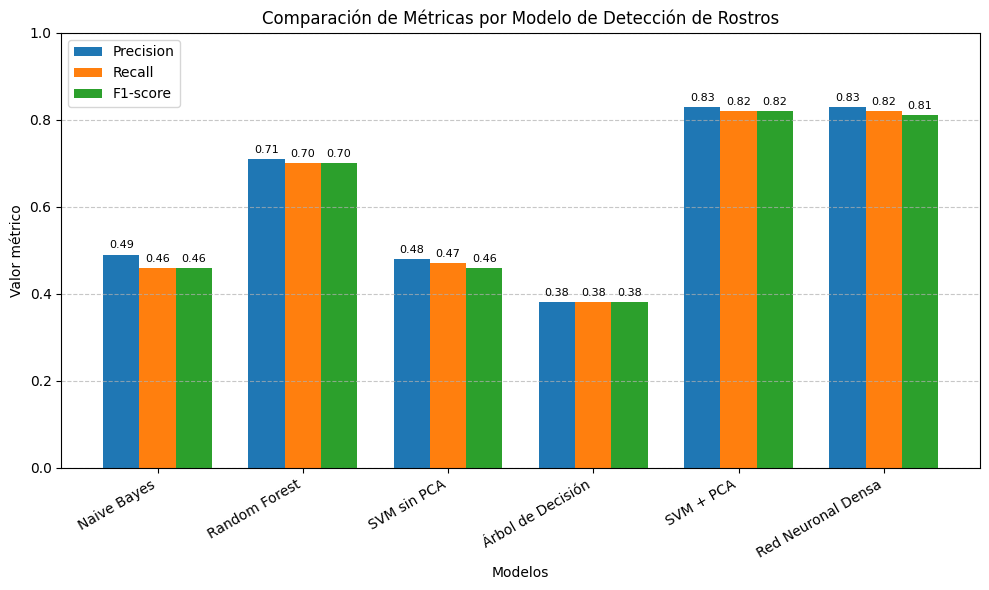

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Nombres de modelos
modelos = ['Naive Bayes', 'Random Forest', 'SVM sin PCA', 'Árbol de Decisión', 'SVM + PCA', 'Red Neuronal Densa']

# Métricas correspondientes
f1_score = [0.46, 0.70, 0.46, 0.38, 0.82, 0.81]
precision = [0.49, 0.71, 0.48, 0.38, 0.83, 0.83]
recall = [0.46, 0.70, 0.47, 0.38, 0.82, 0.82]

x = np.arange(len(modelos))  # posición para las barras

width = 0.25  # ancho de las barras

fig, ax = plt.subplots(figsize=(10,6))

# Barras para cada métrica
bars1 = ax.bar(x - width, precision, width, label='Precision', color='#1f77b4')
bars2 = ax.bar(x, recall, width, label='Recall', color='#ff7f0e')
bars3 = ax.bar(x + width, f1_score, width, label='F1-score', color='#2ca02c')

# Etiquetas y estilo
ax.set_xlabel('Modelos')
ax.set_ylabel('Valor métrico')
ax.set_title('Comparación de Métricas por Modelo de Detección de Rostros')
ax.set_xticks(x)
ax.set_xticklabels(modelos, rotation=30, ha='right')
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valores encima de las barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
